In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

In [2]:
rating = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')
anime_df = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')

print('rating shape:', rating.shape)
print('anime_df shape:', anime_df.shape)

rating shape: (7813737, 3)
anime_df shape: (12294, 7)


In [3]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",TV,51,9.16,151266


## Data Cleaning

- First, it easier for us to create a Recommendation System if the dataset doesn't have a NULL values
- So we'll remove NULL values

In [4]:
null_features = anime_df.columns[anime_df.isna().any()]
anime_df[null_features].isna().sum()

genre     62 
type      25 
rating    230
dtype: int64

In [5]:
anime_df.dropna(inplace=True)

In [6]:
# Perhaps anime name uses japanese or special character so the dataframe couldn't read that
# I just cleaned some error for better names for recommendation

def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)

## EDA

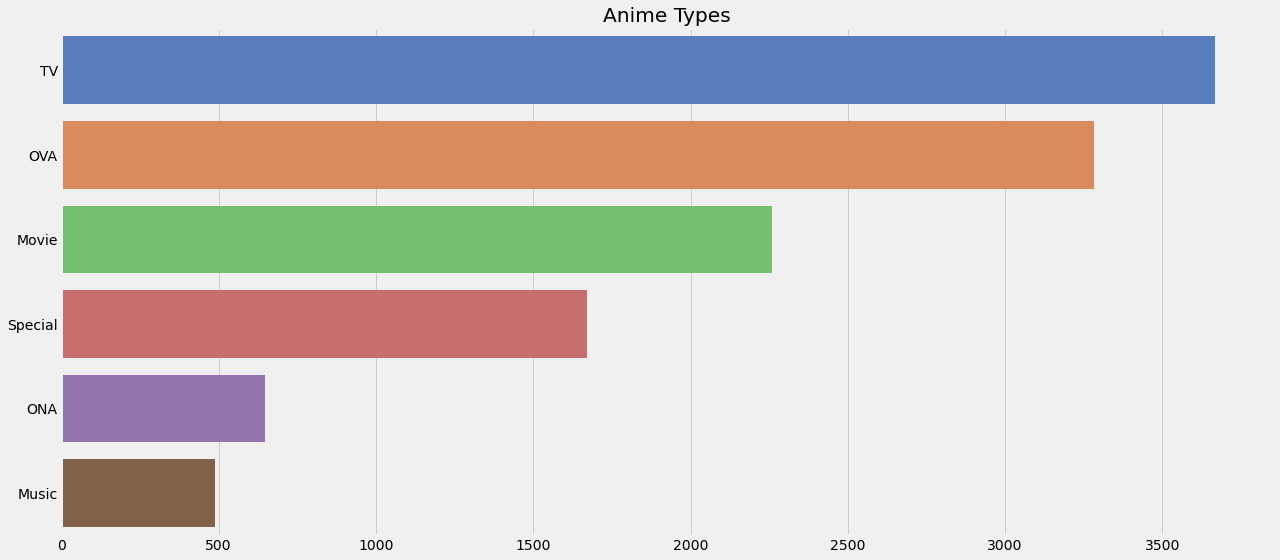

In [7]:
type_count = anime_df['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='muted').set_title('Anime Types')

plt.tight_layout()
plt.show()

## What genres are in the anime dataset?

In [8]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in anime_df['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

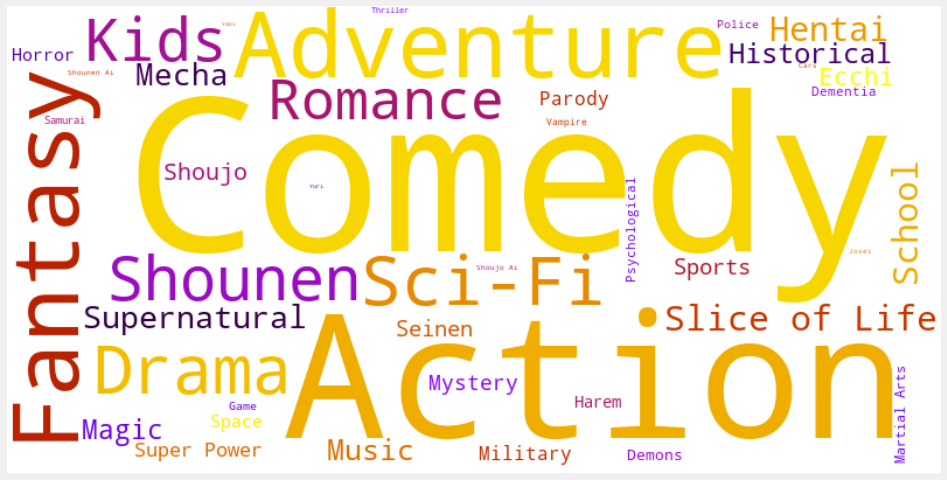

In [9]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Which anime has a longest episodes?

- If you check, why episodes dtype is object, not integer?
- Because episodes has an Unknown values, from my opinion this means countless episodes
- If you're more than 20 years old, most likely you know some of famous anime below

In [10]:
anime_df[anime_df['episodes'] == 'Unknown']['name'][:5]

74      One Piece                             
252     Detective Conan                       
615     Naruto: Shippuuden                    
991     Crayon Shin-chan                      
1021    Tanaka-kun wa Itsumo Kedaruge Specials
Name: name, dtype: object

In [11]:
episodes_count = anime_df[anime_df['episodes'] != 'Unknown'][['name', 'episodes']]
episodes_count['episodes'] = pd.to_numeric(episodes_count['episodes'])

episodes_count.query('episodes>1500')

,name,episodes
929,Doraemon (1979),1787
6296,Oyako Club,1818
9243,Kirin Monoshiri Yakata,1565


## Which anime has the highest rating?

- Here, i only included anime that have more than 500000 of community members
- All top 5 anime are TV series

In [12]:
anime_df[['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>500000')[:5]

,name,rating,members,type
1,Fullmetal Alchemist: Brotherhood,9.26,793665,TV
3,Steins;Gate,9.17,673572,TV
13,Code Geass: Hangyaku no Lelouch R2,8.98,572888,TV
19,Code Geass: Hangyaku no Lelouch,8.83,715151,TV
23,One Punch Man,8.82,552458,TV


### How about movie and OVA (Original Animated Video)?

> OVA is Japanese animated films and series made specially for release in home video formats without prior showings on television or in theatres

In [13]:
anime_df[anime_df['type'] == 'Movie'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>200000')[:5]

,name,rating,members,type
0,Kimi no Na wa.,9.37,200630,Movie
15,Sen to Chihiro no Kamikakushi,8.93,466254,Movie
18,Ookami Kodomo no Ame to Yuki,8.84,226193,Movie
25,Suzumiya Haruhi no Shoushitsu,8.81,240297,Movie
24,Mononoke Hime,8.81,339556,Movie


In [14]:
anime_df[anime_df['type'] == 'OVA'][['name', 'rating', 'members', 'type']].sort_values(by='rating', ascending=False).query('members>100000')[:5]

,name,rating,members,type
21,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,8.83,129307,OVA
66,Hellsing Ultimate,8.59,297454,OVA
245,Detroit Metal City,8.26,104893,OVA
359,Black Lagoon: Robertas Blood Trail,8.15,108099,OVA
456,FLCL,8.06,305165,OVA


## Content-Based Recommendation-System

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

genres_str = anime_df['genre'].str.split(',').astype(str)

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 4), min_df=0)
tfidf_matrix = tfidf.fit_transform(genres_str)

tfidf_matrix.shape
# tfidf.get_feature_names()

(12017, 5569)

In [16]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
indices = pd.Series(anime_df.index, index=anime_df['name'])

def genre_recommendations(title, similarity=False):
    
    if similarity == False:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        
        anime_indices = [i[0] for i in sim_scores]
        
        return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                             'Type': anime_df['type'].iloc[anime_indices].values})
    
    elif similarity == True:
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        
        anime_indices = [i[0] for i in sim_scores]
        similarity_ = [i[1] for i in sim_scores]
        
        return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                             'similarity': similarity_,
                             'Type': anime_df['type'].iloc[anime_indices].values})

## Make a recommendation based on cosine-similarity

- you can choose to prioritize similarity or rating values on your recommendation functions

In [18]:
indices = pd.Series(anime_df.index, index=anime_df['name'])

def genre_recommendations(title, highest_rating=False, similarity=False):
    
    if highest_rating == False:
        if similarity == False:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Type': anime_df['type'].iloc[anime_indices].values})
    
        elif similarity == True:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores]
        
            return pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values})
        
    elif highest_rating == True:
        if similarity == False:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
        
            result_df = pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Type': anime_df['type'].iloc[anime_indices].values,
                                 'Rating': anime_df['rating'].iloc[anime_indices].values})
            
            return result_df.sort_values('Rating', ascending=False)
    
        elif similarity == True:
        
            idx = indices[title]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:11]
        
            anime_indices = [i[0] for i in sim_scores]
            similarity_ = [i[1] for i in sim_scores]
        
            result_df = pd.DataFrame({'Anime name': anime_df['name'].iloc[anime_indices].values,
                                 'Similarity': similarity_,
                                 'Type': anime_df['type'].iloc[anime_indices].values,
                                 'Rating': anime_df['rating'].iloc[anime_indices].values})
            
            return result_df.sort_values('Rating', ascending=False)

In [19]:
genre_recommendations('Doraemon (1979)', highest_rating=True, similarity=True)

,Anime name,Similarity,Type,Rating
5,Doraemon: Obaachan no Omoide,0.924682,Movie,7.44
0,Doraemon Movie 11: Nobita to Animal Planet,1.000000,Movie,7.42
6,Doraemon: Doraemon Comes Back,0.924682,Special,7.39
1,Doraemon Movie 19: Nobita no Nankai Daibouken,1.000000,Movie,7.25
2,Doraemon Movie 16: Nobita no Sousei Nikki,1.000000,Movie,7.23
7,Doraemon: The Day When I Was Born,0.924682,Movie,7.15
8,The☆Doraemons: The Mysterious Thief Dorapan The Mysterious Cartel,0.924682,Movie,7.04
3,Dorami and Doraemons: Space Lands Critical Event,1.000000,Movie,6.93
4,The☆Doraemons: Dokidoki Kikansha Daibakusou!,1.000000,Movie,6.87
9,Doraemon: Featherplace,0.924682,Special,6.82


In [20]:
genre_recommendations('Naruto: Shippuuden', highest_rating=False, similarity=False)

,Anime name,Type
0,Naruto: Shippuuden,TV
1,Naruto,TV
2,Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi,Special
3,Naruto x UT,OVA
4,Naruto: Shippuuden Movie 4 - The Lost Tower,Movie
5,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono,Movie
6,Naruto Shippuuden: Sunny Side Battle,Special
7,Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!,Movie
8,Battle Spirits: Ryuuko no Ken,OVA
9,Kyutai Panic Adventure!,Special


## Deep Learning for collaborative filtering

- Neural networks are fundamentally matrix operations.
- Matrix factorization techniques for recommendation systems also doing something similar.
- For example: in SVD, We find matrices using weights calculated by SGD, Which is similar to Deep Learning
- Even though by small margins, in some researches Deep Learning can outperformed SVD!

In [21]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


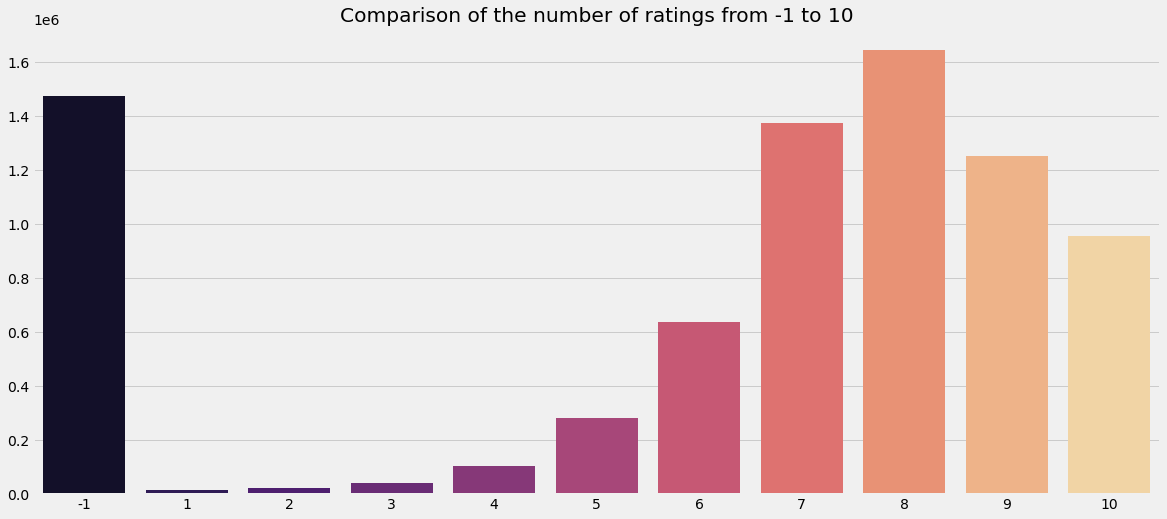

In [22]:
rating_count = rating['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='magma').set_title('Comparison of the number of ratings from -1 to 10');

# Computational efficiency strategy

- In real world, many users don't want to give a rating for any reason, maybe because they're lazy (like me)
- Although we can include all ratings (with Null rating), i only use rating values from 6 to 10 for computational efficiency
    - -1 means the user watched it but didn't assign a rating, so i decided to remove this, including 1,2,3,4,5
- Last, we filter user_id from 1 - 10.000

**Computational efficiency measures the amount of time or memory required for a given step in a calculation**

In [23]:
### step 1 - filter only rating from 6 to 10

mask = (rating['rating'] == -1) | (rating['rating'] == 1) | (rating['rating'] == 2) | (rating['rating'] == 3) | (rating['rating'] == 4) | (rating['rating'] == 5)

rating = rating.loc[~mask]

In [24]:
### step 2 - changed rating value from 6 - 10, to 1 - 5

def change_rating(rating):
    if rating == 6:
        return 1
    elif rating == 7:
        return 2
    elif rating == 8:
        return 3
    elif rating == 9:
        return 4
    elif rating == 10:
        return 5
    
rating['rating'] = rating['rating'].apply(change_rating)

In [25]:
### step 3 - filter user_id from 1 to 10000 only

rating = rating[rating['user_id'] < 10000]

In [26]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
rating['user_id'] = user_enc.fit_transform(rating['user_id'])

anime_enc = LabelEncoder()
rating['anime_id'] = anime_enc.fit_transform(rating['anime_id'])

In [27]:
userid_nunique = rating['user_id'].nunique()
anime_nunique = rating['anime_id'].nunique()

print('User_id total unique:', userid_nunique)
print('Anime_id total unique:', anime_nunique)

User_id total unique: 9450
Anime_id total unique: 7624


In [28]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

print('Using tensorflow version:', tf.__version__)

Using tensorflow version: 2.1.0


In [29]:
def RecommenderV2(n_users, n_movies, n_dim):
    
    # User
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Anime
    movie = Input(shape=(1,))
    M = Embedding(n_movies, n_dim)(movie)
    M = Flatten()(M)
    
    # Gabungkan disini
    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dropout = Dropout(0.5)(dense_1)
    final = Dense(1)(dropout)
    
    model = Model(inputs=[user, movie], outputs=final)
    
    model.compile(optimizer=Adam(0.001),
                  loss='mean_squared_error')
    
    return model

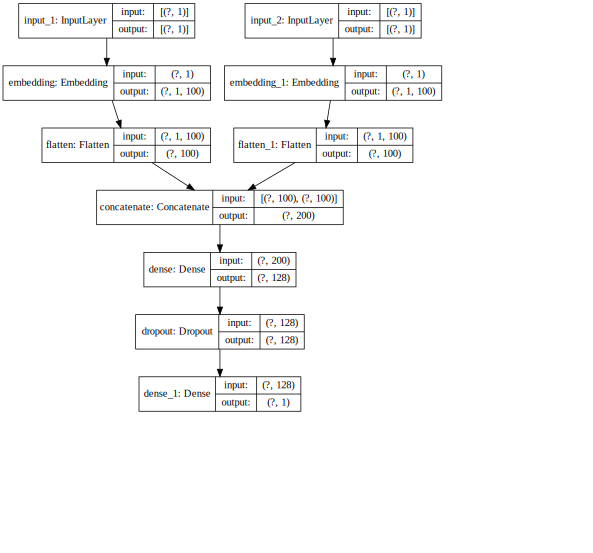

In [30]:
model = RecommenderV2(userid_nunique, anime_nunique, 100)

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       945000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       762400      input_2[0][0]                    
______________________________________________________________________________________________

In [32]:
from sklearn.model_selection import train_test_split

X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.1,
                                                  stratify=y,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((706664, 2), (78519, 2), (706664,), (78519,))

In [33]:
checkpoint = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)

In [34]:
history = model.fit(x=[X_train['user_id'], X_train['anime_id']],
                    y=y_train,
                    batch_size=64,
                    epochs=20,
                    verbose=1,
                    validation_data=([X_val['user_id'], X_val['anime_id']], y_val),
                    callbacks=[checkpoint])

Train on 706664 samples, validate on 78519 samples
Epoch 1/20
706664/706664 [==============================] - 111s 158us/sample - loss: 1.1833 - val_loss: 0.9835
Epoch 2/20
706664/706664 [==============================] - 107s 152us/sample - loss: 0.9785 - val_loss: 0.9519
Epoch 3/20
706664/706664 [==============================] - 106s 150us/sample - loss: 0.9477 - val_loss: 0.9411
Epoch 4/20
706664/706664 [==============================] - 108s 153us/sample - loss: 0.9318 - val_loss: 0.9333
Epoch 5/20
706664/706664 [==============================] - 109s 154us/sample - loss: 0.9180 - val_loss: 0.9316
Epoch 6/20
706664/706664 [==============================] - 109s 154us/sample - loss: 0.9063 - val_loss: 0.9283
Epoch 7/20
706664/706664 [==============================] - 104s 147us/sample - loss: 0.8966 - val_loss: 0.9304
Epoch 8/20
706664/706664 [==============================] - 104s 147us/sample - loss: 0.8863 - val_loss: 0.9233
Epoch 9/20
706664/706664 [===========================

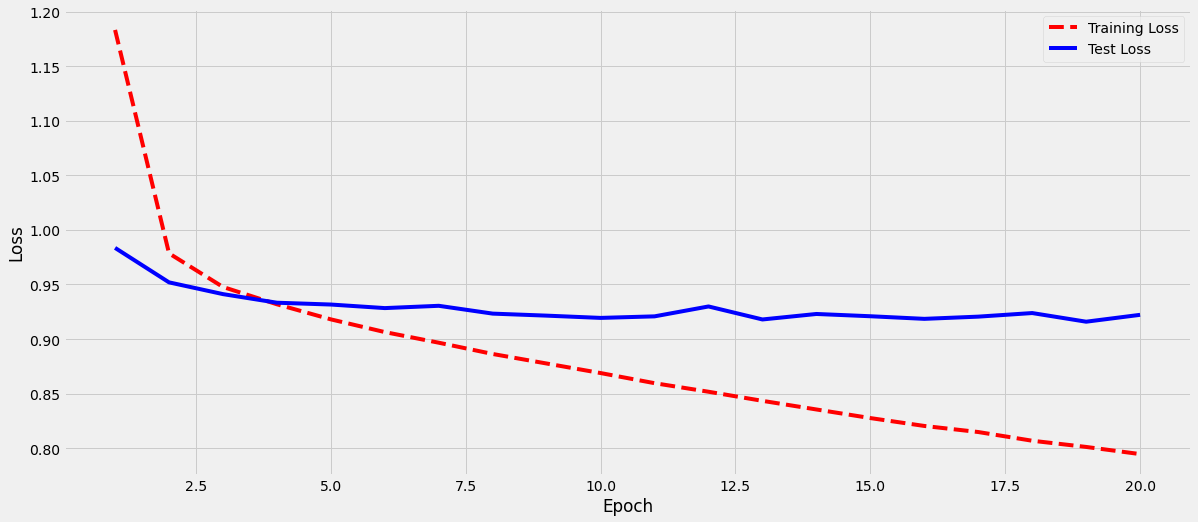

In [35]:
# Get training and test loss histories
training_loss2 = history.history['loss']
test_loss2 = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [36]:
from tensorflow.keras.models import load_model

model = load_model('model1.h5')

In [37]:
def make_pred(user_id, anime_id, model):
    return model.predict([np.array([user_id]), np.array([anime_id])])[0][0]

In [48]:
def get_topN_rec(user_id, model):
    
    user_id = int(user_id) - 1
    user_ratings = rating[rating['user_id'] == user_id]
    recommendation = rating[~rating['anime_id'].isin(user_ratings['anime_id'])][['anime_id']].drop_duplicates()
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(user_id, x['anime_id'], model), axis=1)
    
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(anime_df[['anime_id', 'name', 'type', 'members']],
                                                                                       on='anime_id').head(10)
    
    return final_rec.sort_values('rating_predict', ascending=False)[['name', 'type', 'rating_predict']]

In [49]:
get_topN_rec(23, model)

,name,type,rating_predict
0,Yumemiru Topo Gigio,TV,5.656672
1,Doraemon Movie 30: Nobita no Ningyo Daikaisen,Movie,5.566058
2,Eikoku Koi Monogatari Emma: Intermission,Special,5.405535
3,Galaxy Angel,TV,5.398612
4,Devilman,TV,5.367026
5,IGPX: Immortal Grand Prix,TV,5.306803
6,Hyakka Zukan,Movie,5.268671
7,Precure All Stars Movie DX: Minna Tomodachi☆Kiseki no Zenin Daishuugou!,Movie,5.256227
8,Shukufuku no Campanella,TV,5.226894
9,Utsunomiko: Heaven Chapter,OVA,5.226095


## Closing

- If you're interested, you can tuning model hyperparameter for better accuracy
- BUT REMEMBER, accuracy isn't indicator whether this model can provide good recommendations or not
- We should focus on TopN recommendation; you can upgrade a function to not only give recommendation based on rating (predict), but also based on members, episodes etc

Also you can check my final project kernel (about recommendation system) if you're interested, 谢谢你

https://www.kaggle.com/indralin/movielens-project-1-1-content-based

https://www.kaggle.com/indralin/movielens-project-1-2-collaborative-filtering

https://www.kaggle.com/indralin/movielens-project-1-3-deep-learning